In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('train.csv')
orig_df=pd.read_csv('Churn_Modelling.csv').rename(columns={'RowNumber':'id'})
df_test=pd.read_csv('test.csv')

In [3]:
df=pd.concat([df,orig_df],ignore_index=True)
df.drop(['id'],axis=1,inplace=True)

In [4]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175036 entries, 0 to 175035
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       175036 non-null  int64  
 1   Surname          175036 non-null  object 
 2   CreditScore      175036 non-null  int64  
 3   Geography        175035 non-null  object 
 4   Gender           175036 non-null  object 
 5   Age              175035 non-null  float64
 6   Tenure           175036 non-null  int64  
 7   Balance          175036 non-null  float64
 8   NumOfProducts    175036 non-null  int64  
 9   HasCrCard        175035 non-null  float64
 10  IsActiveMember   175035 non-null  float64
 11  EstimatedSalary  175036 non-null  float64
 12  Exited           175036 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 17.4+ MB


In [6]:
df.isnull().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import pandas as pd

def tfidf_pca_transformer(data, column, max_features, n_components):
    vectorizer = TfidfVectorizer(max_features=max_features)
    tfidf_matrix = vectorizer.fit_transform(data[column])

    svd = TruncatedSVD(n_components=n_components)
    svd_result = svd.fit_transform(tfidf_matrix)

    tfidf_df = pd.DataFrame(svd_result, columns=[f"{column}_tfidf_{i}" for i in range(n_components)])
    result_df = pd.concat([data, tfidf_df], axis='columns')

    return result_df

In [9]:
object_dat=['Geography', 'Gender']

In [10]:
from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()
lb.fit(df['Surname'])
def preprocess(data):
    data = tfidf_pca_transformer(data, column="Surname", max_features=1000, n_components=5)
    
    data.drop(['CustomerId'],axis=1,inplace=True)
    data.dropna(inplace=True)
    
    data['Surname']=lb.transform(data['Surname'])
    
    for i in object_dat:
        data=pd.concat([data,pd.get_dummies(data[i])*1],axis=1)
        data.drop([i],axis=1,inplace=True)
    
    data['Age']=data['Age'].round()
    data['Mem__no__Products'] = data['NumOfProducts'] * data['IsActiveMember']
    data["Cred_Bal_Sal"] = (data["CreditScore"] * data["Balance"] ) / data["EstimatedSalary"]
    data["Bal_sal"] = data["Balance"] / data["EstimatedSalary"]
    data["Tenure_Age"] = data["Tenure"] / data["Age"]
    data["Age_Tenure_product"] = data["Age"] * data["Tenure"]
    data["IsSenior"] = data['Age'].apply(lambda x: 1 if x >= 60 else 0)
    
    scaling_cols = ['Age','Tenure','CreditScore','Balance','EstimatedSalary','Cred_Bal_Sal','Bal_sal','Age_Tenure_product']
    for i in scaling_cols:
        min_val=data[i].min()
        max_val=data[i].max()
        data[f'{i}_sc']=(data[i]-min_val)/(max_val-min_val)
    
    data['HasCrCard'] = data['HasCrCard'].astype('int64')
    data['IsActiveMember'] = data['IsActiveMember'].astype('int64')
    data['Age'] = data['Age'].astype('int64')
    return data

In [11]:
df=preprocess(df)
df['Exited'] = df['Exited'].astype('int64')

In [12]:
df.head()

,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,...,Age_Tenure_product,IsSenior,Age_sc,Tenure_sc,CreditScore_sc,Balance_sc,EstimatedSalary_sc,Cred_Bal_Sal_sc,Bal_sal_sc,Age_Tenure_product_sc
0,2023,668.0,33,3.0,0.00,2.0,1,0,181449.97,0,...,99.0,0,0.202703,0.3,0.636,0.000000,0.907279,0.000000,0.000000,0.112500
1,2024,627.0,33,1.0,0.00,2.0,1,1,49503.50,0,...,33.0,0,0.202703,0.1,0.554,0.000000,0.247483,0.000000,0.000000,0.037500
2,1236,678.0,40,10.0,0.00,2.0,1,0,184866.69,0,...,400.0,0,0.297297,1.0,0.656,0.000000,0.924364,0.000000,0.000000,0.454545
3,1362,581.0,34,2.0,148882.54,1.0,1,1,84560.88,0,...,68.0,0,0.216216,0.2,0.462,0.593398,0.422787,0.000118,0.000137,0.077273
4,491,716.0,33,5.0,0.00,2.0,1,1,15068.83,0,...,165.0,0,0.202703,0.5,0.732,0.000000,0.075293,0.000000,0.000000,0.187500


In [13]:
df.to_csv('Dataset.csv',index=False)

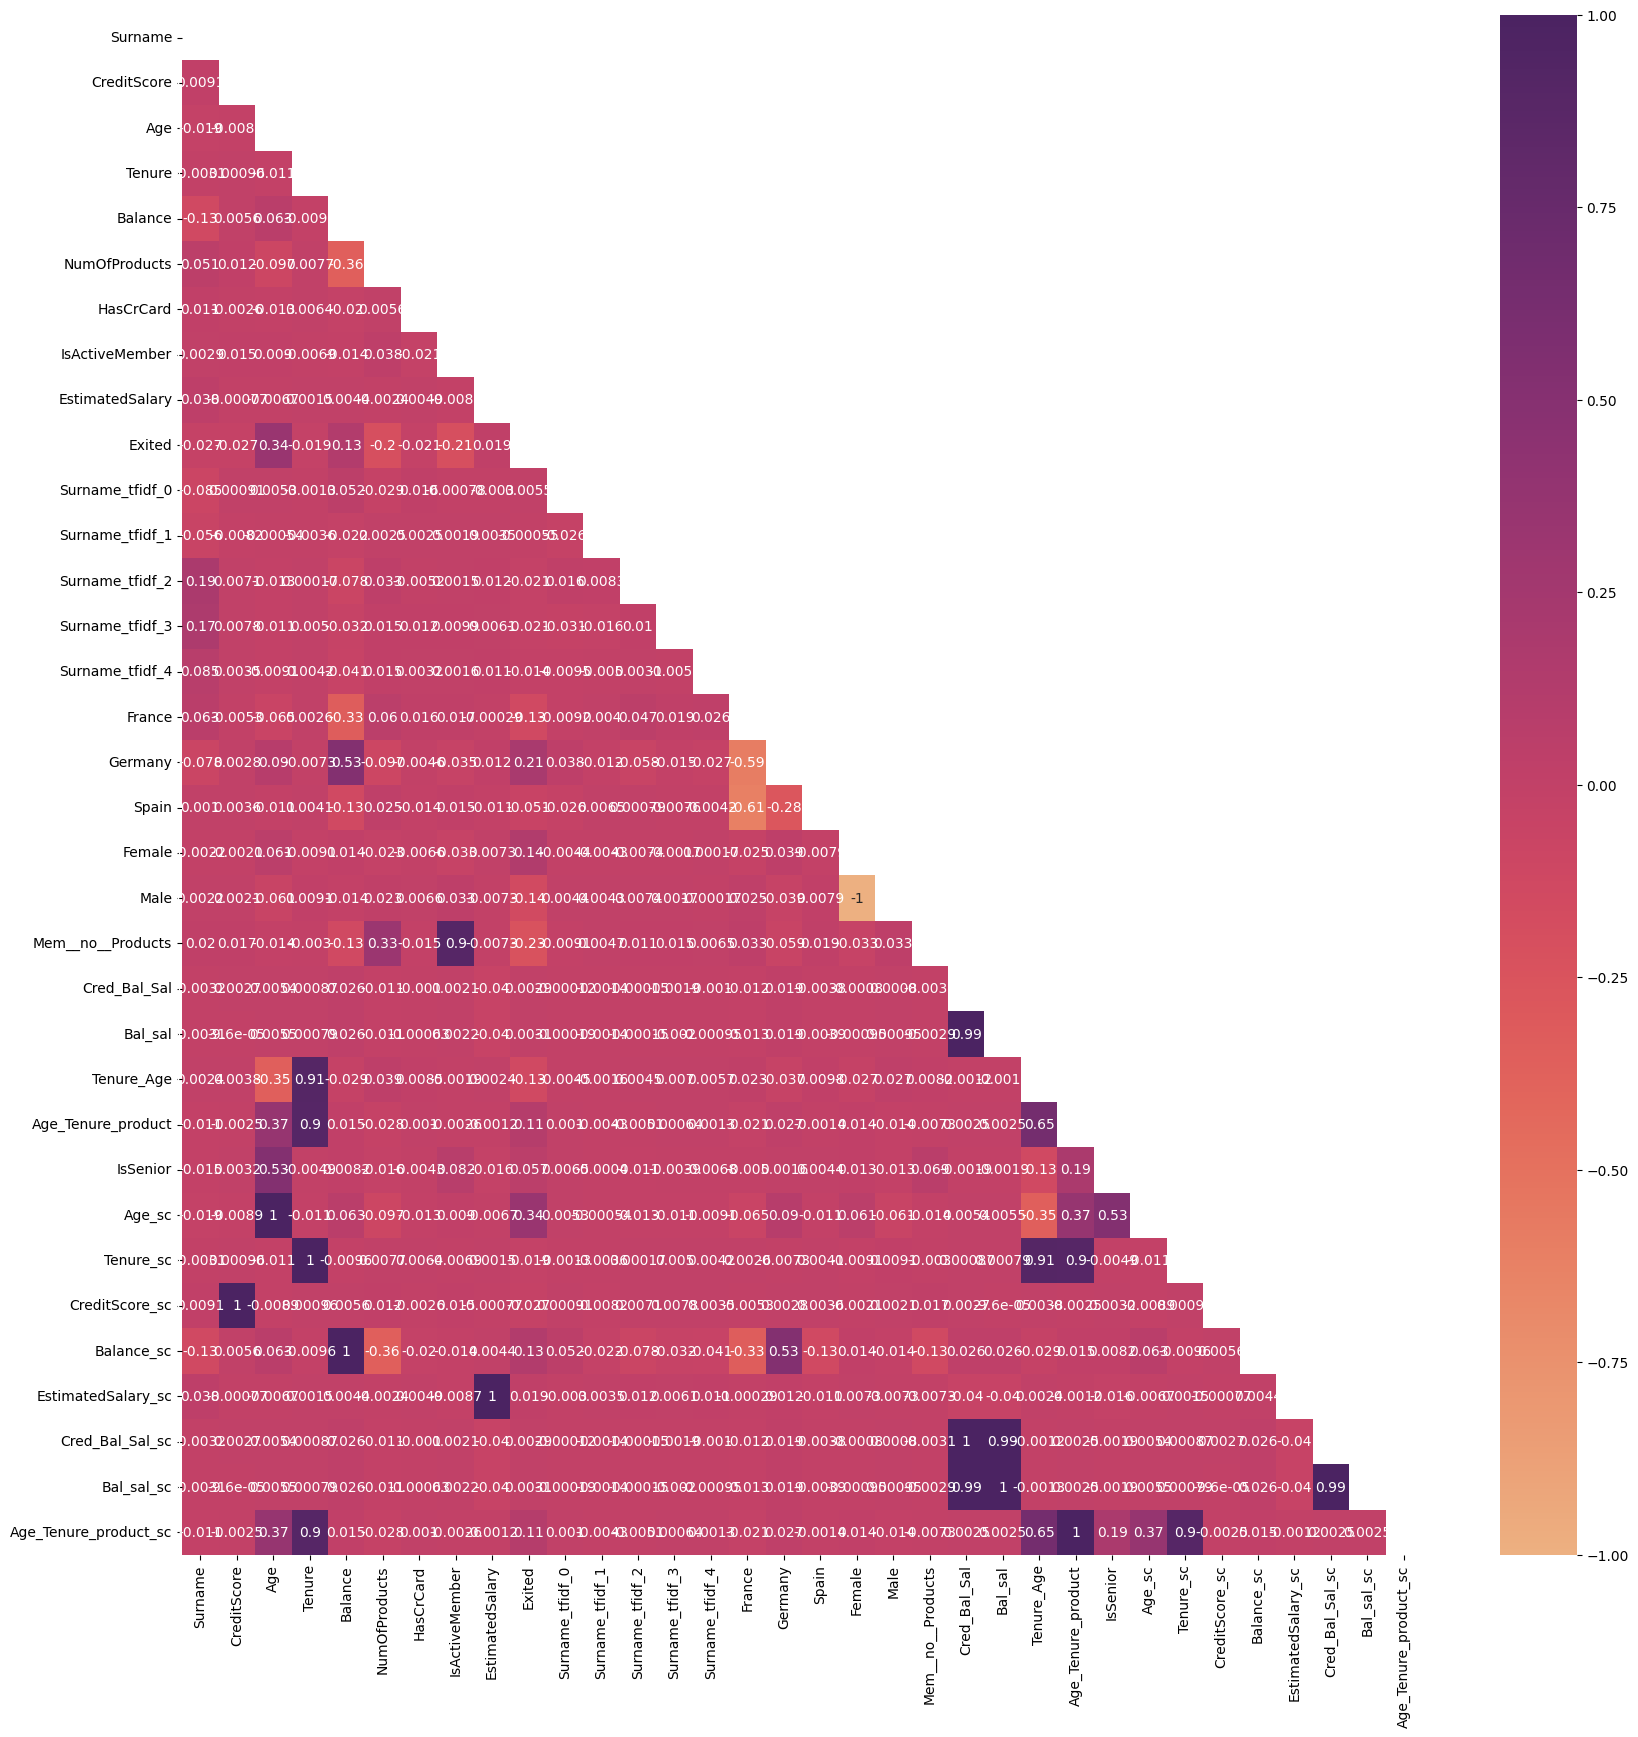

In [14]:
#Correlation Matrix

plt.figure(figsize=(20,20))
corr=df.corr()
sns.heatmap(corr,annot=True,cmap='flare',mask=np.triu(corr))
plt.show()

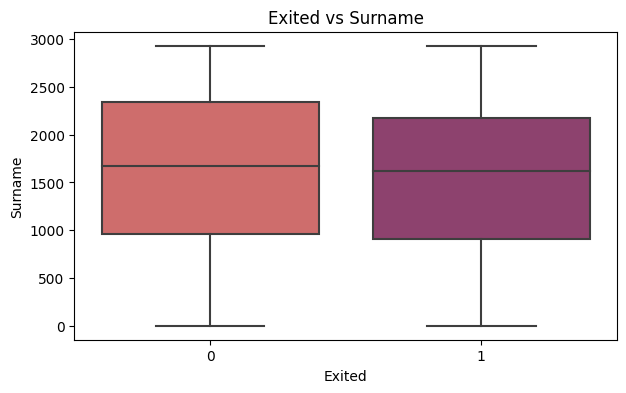

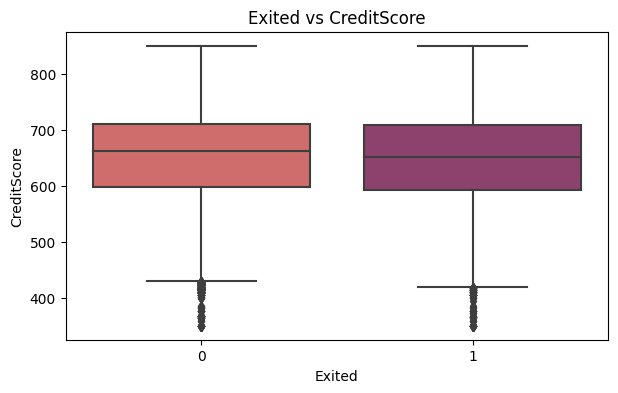

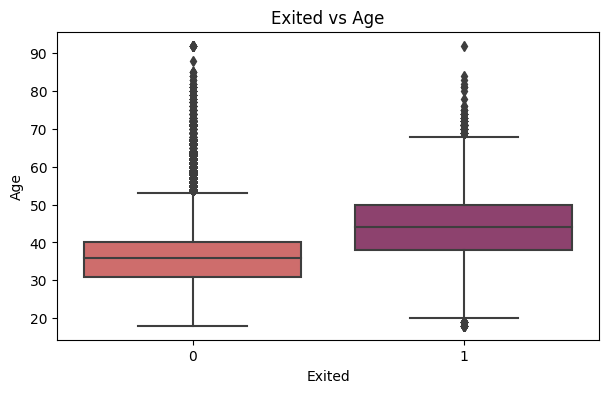

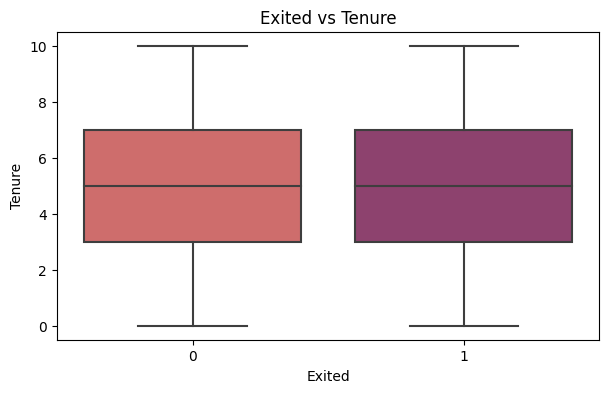

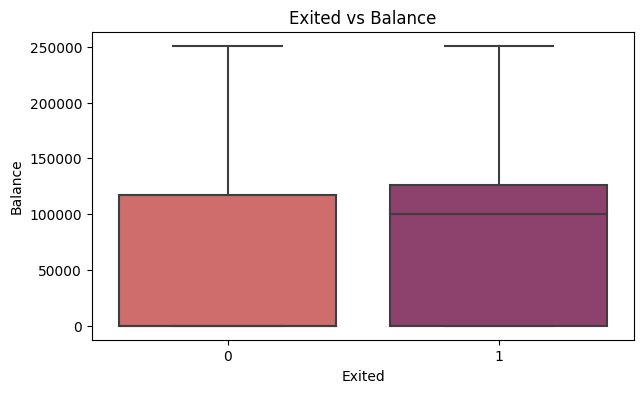

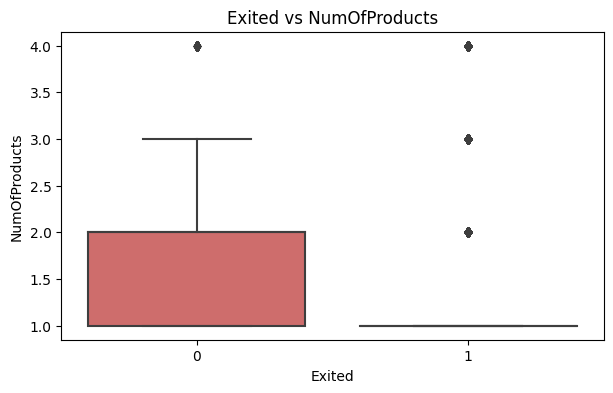

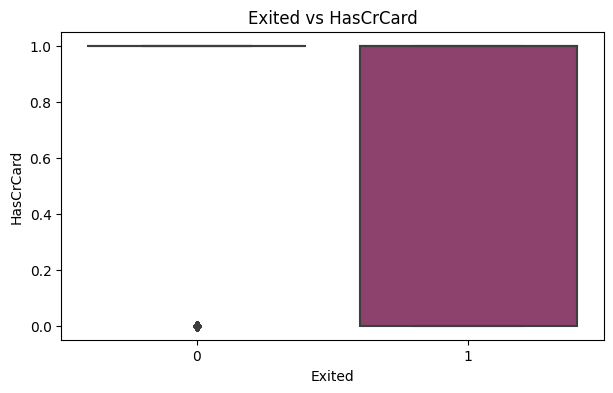

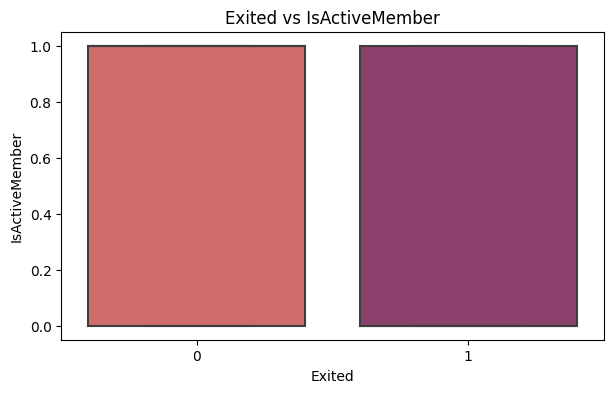

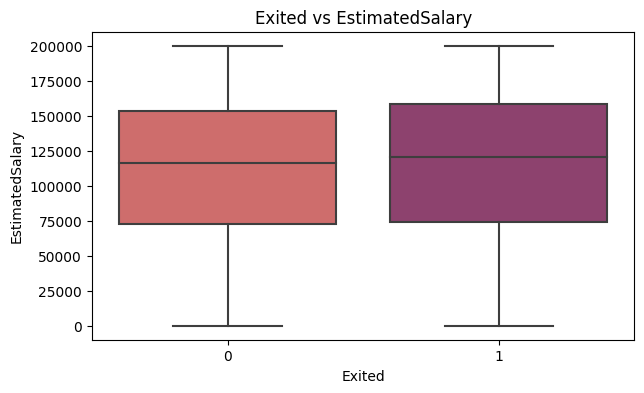

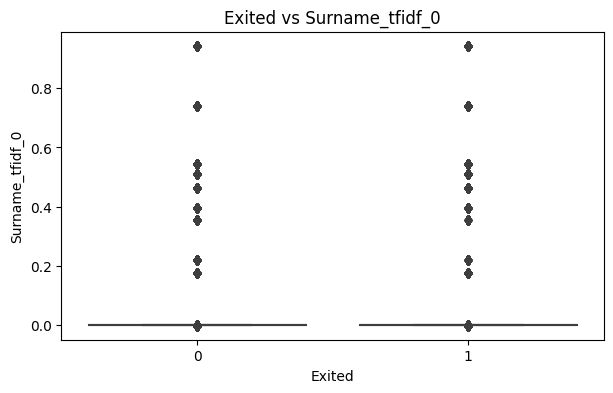

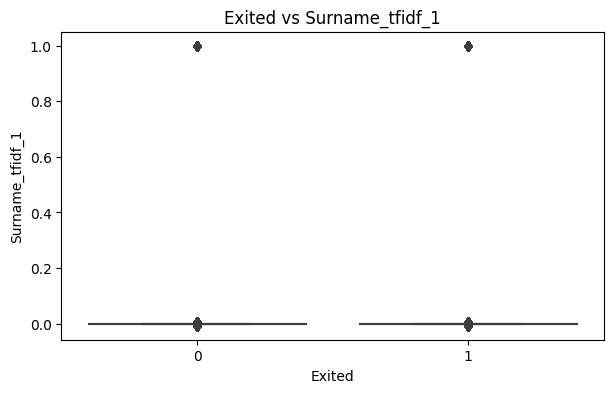

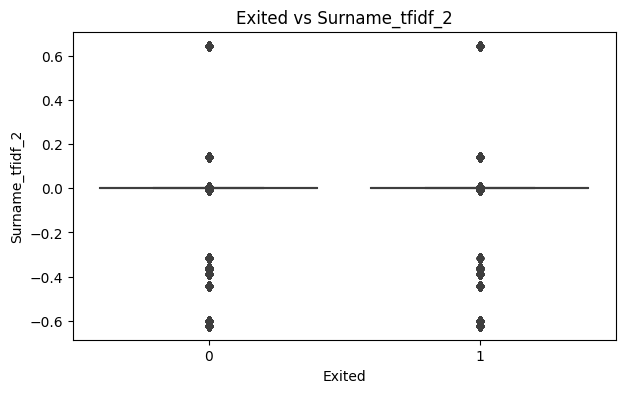

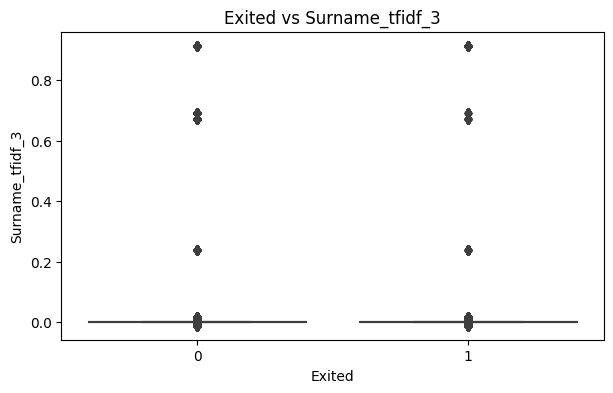

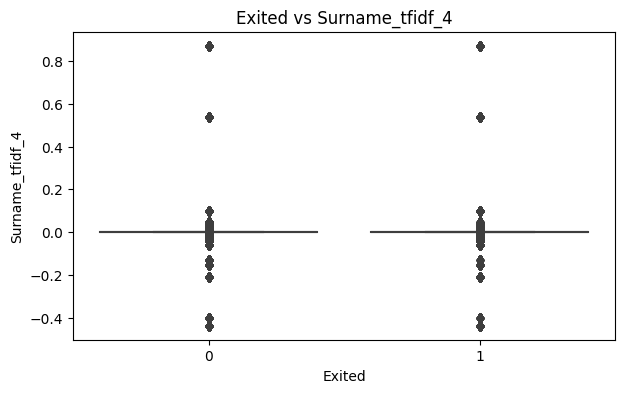

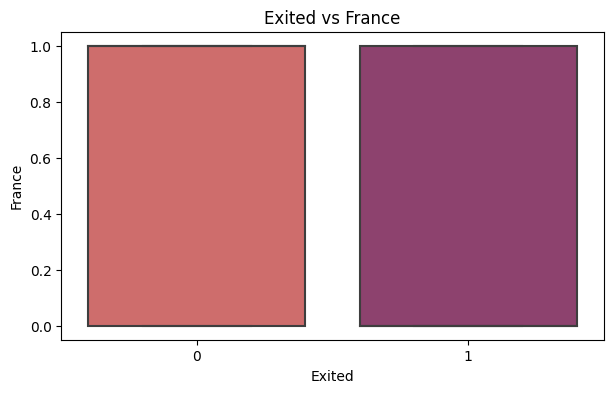

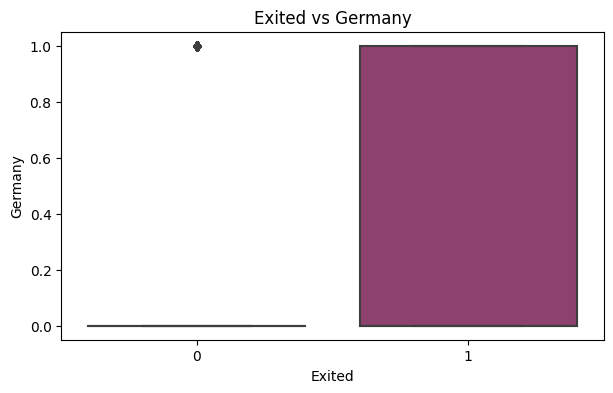

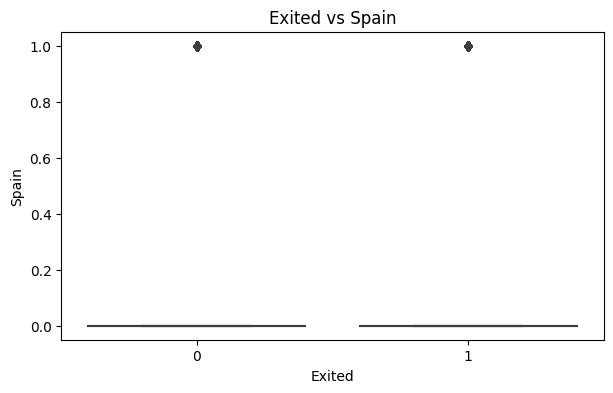

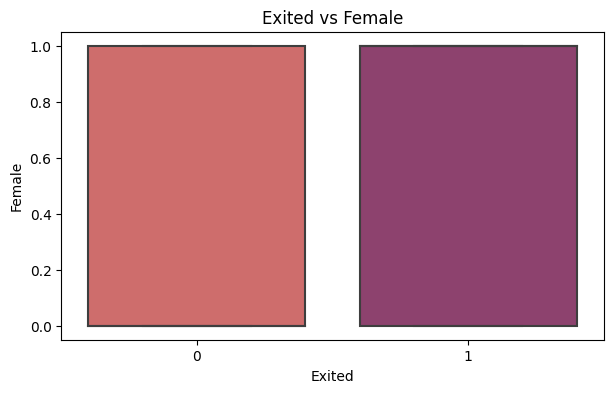

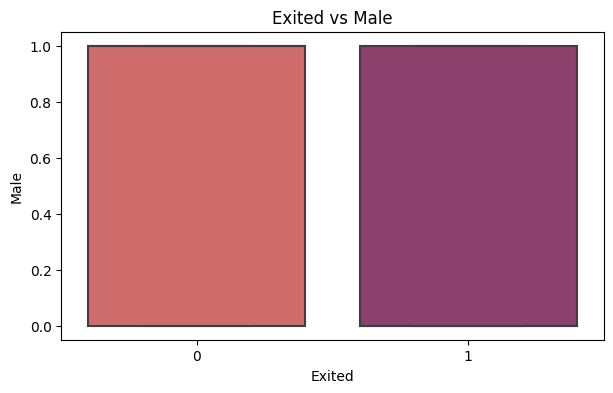

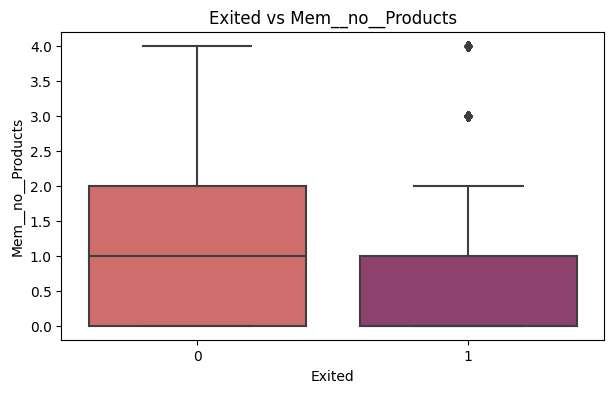

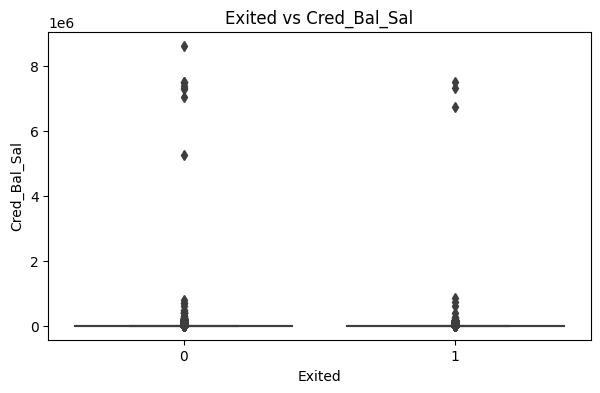

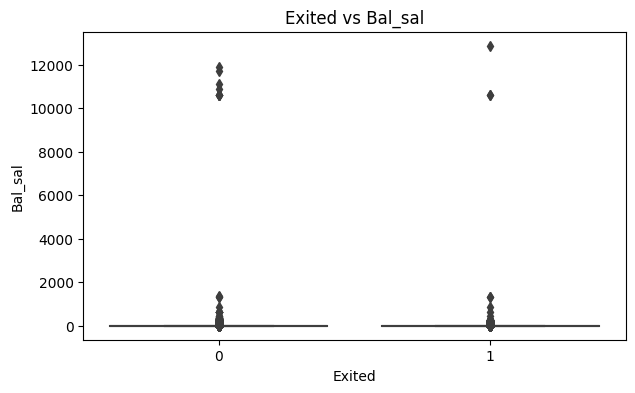

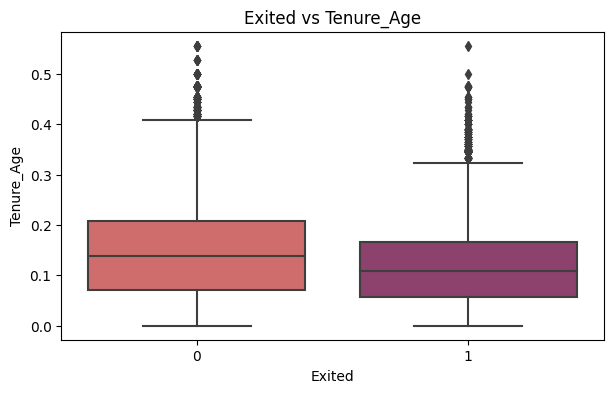

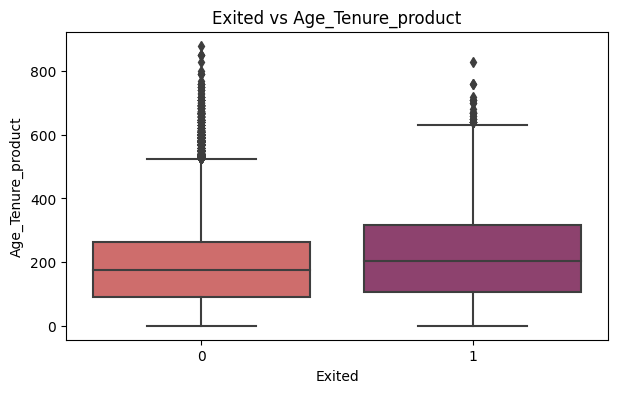

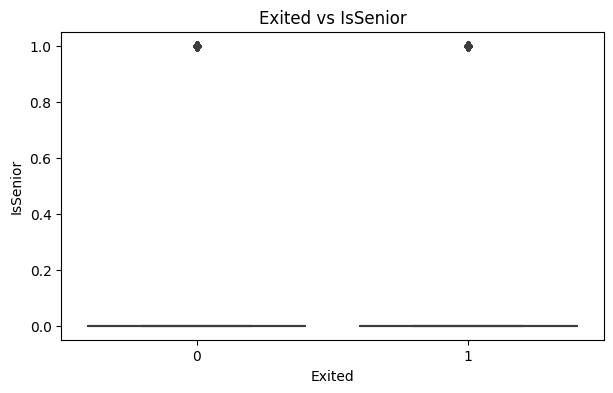

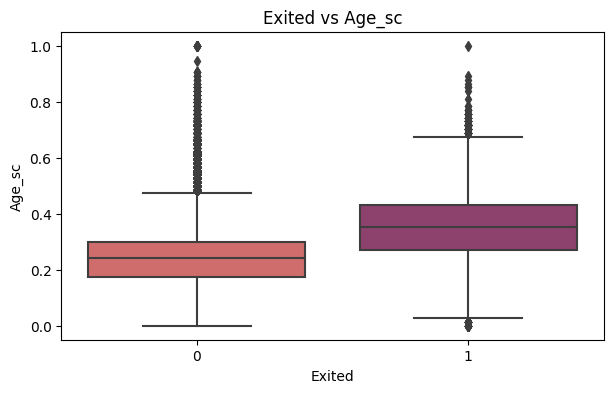

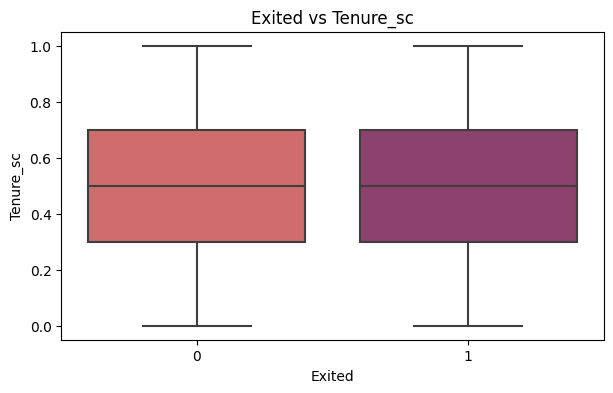

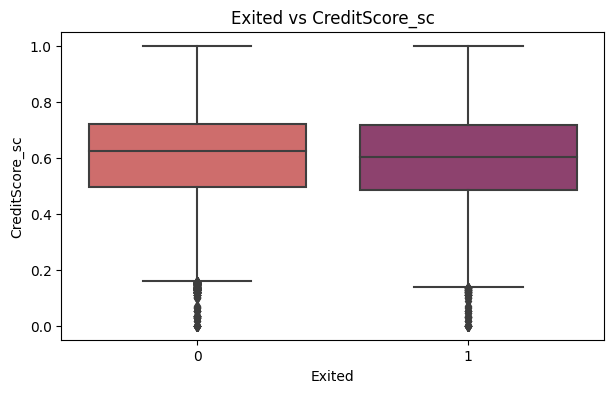

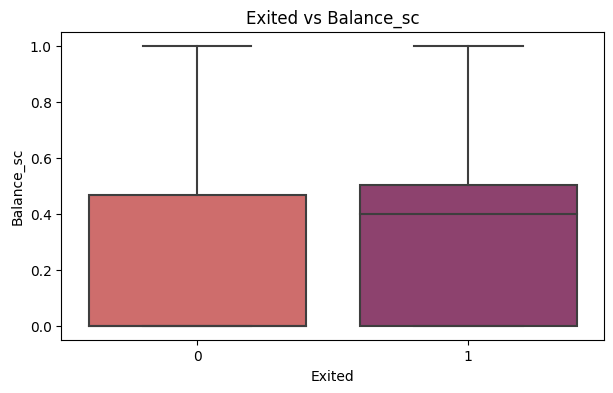

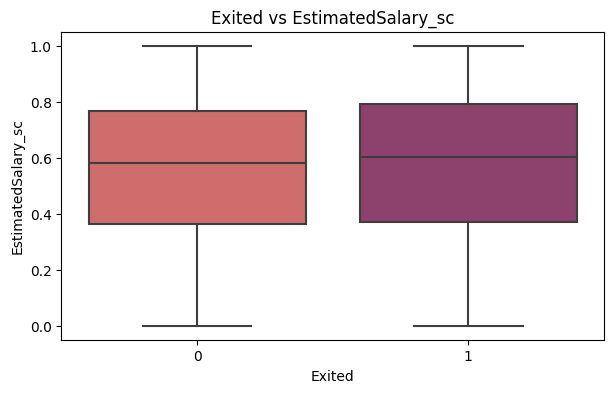

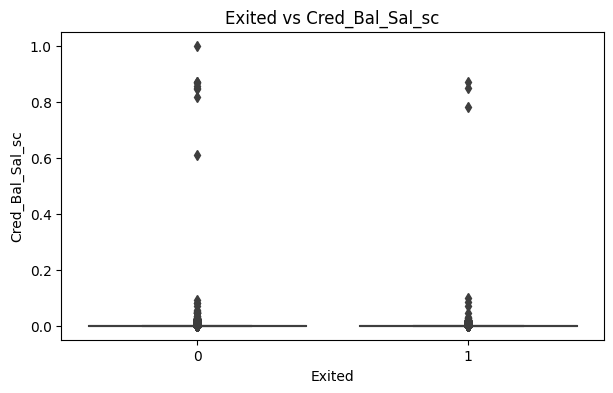

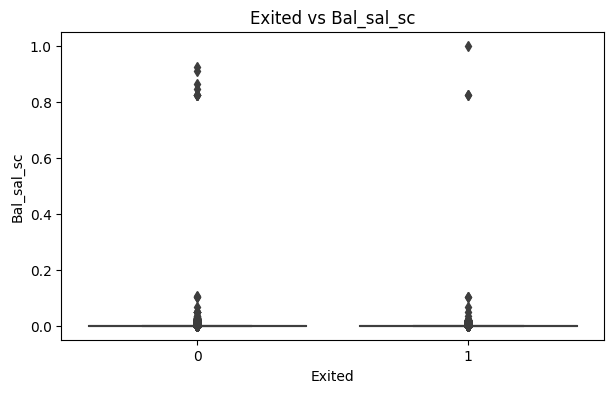

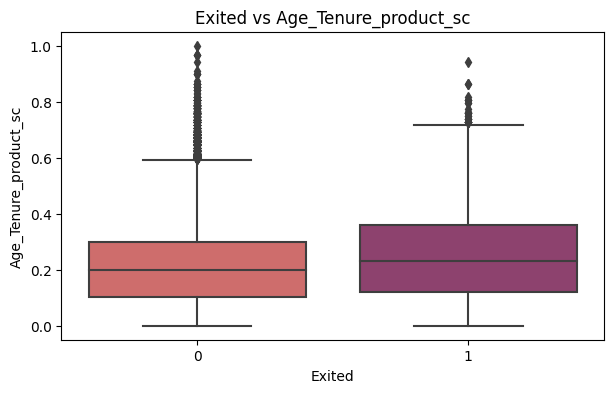

In [15]:
for col in df.columns:
    if col!='Exited':
        plt.figure(figsize=(7,4))
        sns.boxplot(df,x='Exited',y=col,palette='flare')
        plt.gca().set_title(f'Exited vs {col}')
        plt.show()

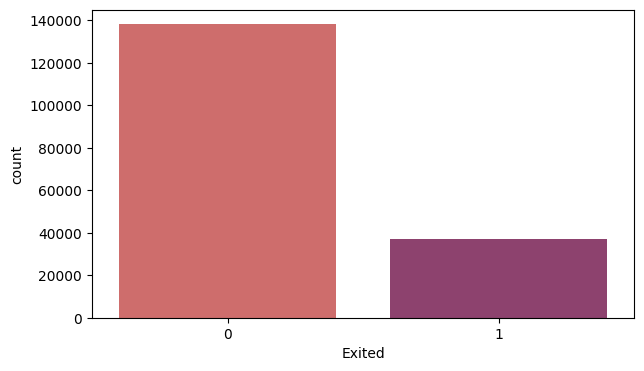

In [16]:
plt.figure(figsize=(7,4))
sns.countplot(df,x='Exited',palette='flare')
plt.show()

In [17]:
x=df.drop(['Exited'],axis=1)
y=df[['Exited']]

In [18]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=42,shuffle=True)

In [19]:
DTC=DecisionTreeClassifier(random_state=0)
LR=LogisticRegression()
RFC=RandomForestClassifier(n_estimators=23,random_state=0)
KNN=KNeighborsClassifier(n_neighbors=5,metric='minkowski',p=2)
NB=GaussianNB()

In [20]:
DTC.fit(x_train,y_train)
LR.fit(x_train,y_train)
RFC.fit(x_train,y_train)
KNN.fit(x_train,y_train)
NB.fit(x_train,y_train)

GaussianNB()

In [21]:
pred_DTC=DTC.predict_proba(x_test)
pred_DTC=[i[1] for i in pred_DTC]
pred_LR=LR.predict_proba(x_test)
pred_LR=[i[1] for i in pred_LR]
pred_RFC=RFC.predict_proba(x_test)
pred_RFC=[i[1] for i in pred_RFC]
pred_KNN=KNN.predict_proba(x_test)
pred_KNN=[i[1] for i in pred_KNN]
pred_NB=NB.predict_proba(x_test)
pred_NB=[i[1] for i in pred_NB]

In [22]:
print("Decision Tree Classification ROC score =",roc_auc_score(y_test,pred_DTC))
print("****************************************************************")
print("Logistic Regression ROC score =",roc_auc_score(y_test,pred_LR))
print("****************************************************************")
print("Random Forest Classification ROC score =",roc_auc_score(y_test,pred_RFC))
print("****************************************************************")
print("K Nearest Neighbors ROC score =",roc_auc_score(y_test,pred_KNN))
print("****************************************************************")
print("Naive Bayes ROC score =",roc_auc_score(y_test,pred_NB))

Decision Tree Classification ROC score = 0.705013805168776
****************************************************************
Logistic Regression ROC score = 0.6136590585686408
****************************************************************
Random Forest Classification ROC score = 0.8633434520911261
****************************************************************
K Nearest Neighbors ROC score = 0.5574832743255944
****************************************************************
Naive Bayes ROC score = 0.7728143137173491


In [23]:
from sklearn.ensemble import GradientBoostingClassifier
GBC=GradientBoostingClassifier()
GBC.fit(x_train,y_train)

GradientBoostingClassifier()

In [24]:
pred_GBC=GBC.predict_proba(x_test)
pred_GBC=[i[1] for i in pred_GBC]
print("Gradient Boosting ROC score =",roc_auc_score(y_test,pred_GBC))

Gradient Boosting ROC score = 0.8889653200572213


In [25]:
from xgboost import XGBClassifier
# XGB_params = {'booster': 'gbtree', 
#         'lambda': 8.803747805736341e-08, 
#         'alpha': 0.00010339545129413926,
#         'subsample': 0.6472067107394853,
#         'colsample_bytree': 0.9225973102702412,
#         'max_depth': 5,
#         'min_child_weight': 5,
#         'eta': 0.12477845463556776,
#         'gamma': 0.0021228439224434607,
#         'grow_policy': 'lossguide'}
XGB_params={'n_estimators': 1580,
                      'learning_rate': 0.01549093838586683,
                      'alpha': 0.926917946207397,
                      'subsample': 0.8749127473190033,
                      'colsample_bytree': 0.5264186380747528,
                      'max_depth': 6,
                      'min_child_weight': 1,
                      'gamma': 0.003713337191882183}

XGB=XGBClassifier(**XGB_params)
XGB.fit(x_train,y_train)

XGBClassifier(alpha=0.926917946207397, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5264186380747528, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.003713337191882183,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01549093838586683,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1580, n_jobs=None,
              num_parallel_tree=None, ...)

In [26]:
pred_XGB=XGB.predict_proba(x_test)
pred_XGB=[i[1] for i in pred_XGB]
print("XGB ROC score =",roc_auc_score(y_test,pred_XGB))

XGB ROC score = 0.8945308743210649


In [28]:
from sklearn.ensemble import AdaBoostClassifier
ABC=AdaBoostClassifier()
ABC.fit(x_train,y_train)

AdaBoostClassifier()

In [29]:
pred_ABC=ABC.predict_proba(x_test)
pred_ABC=[i[1] for i in pred_ABC]
print("AdaBoost ROC score =",roc_auc_score(y_test,pred_ABC))

AdaBoost ROC score = 0.8798708906897362


In [30]:
from catboost import CatBoostClassifier
CBC_params = {'iterations': 2348, 
                     'learning_rate': 0.027888186114456686,
                     'colsample_bylevel': 0.6678237610072195,
                     'random_strength': 0.09963299754527431,
                     'depth': 5,
                     'l2_leaf_reg': 7, 
                     'boosting_type': 'Plain',
                     'bootstrap_type': 'Bernoulli', 
                     'subsample': 0.7831829918510387}
CBC=CatBoostClassifier(**CBC_params,verbose=0)
CBC.fit(x_train,y_train)

In [31]:
pred_CBC=CBC.predict_proba(x_test)
pred_CBC=[i[1] for i in pred_CBC]
print("CatBoost ROC score =",roc_auc_score(y_test,pred_CBC))

CatBoost ROC score = 0.8939555457209323


In [32]:
from lightgbm import LGBMClassifier
# LGB_params = {'n_estimators':1378,
#                'max_depth': 45, 
#                'learning_rate': 0.02280891846048891,
#                'min_child_weight': 2.829627687023079, 
#                'min_child_samples': 239,
#                'subsample': 0.9770315658429933,
#                'subsample_freq': 2,
#                'colsample_bytree': 0.6533317052372195,
#                'num_leaves': 44}

LGB_params={'n_estimators': 2401,
                     'max_depth': 7,
                     'learning_rate': 0.01640467465265993,
                     'min_child_samples': 80,
                     'subsample': 0.7767380002390929,
                     'max_bin': 280,
                     'colsample_bytree': 0.4146684747000371}
LGB=LGBMClassifier(**LGB_params)
LGB.fit(x_train,y_train)

LGBMClassifier(colsample_bytree=0.4146684747000371,
               learning_rate=0.01640467465265993, max_bin=280, max_depth=7,
               min_child_samples=80, n_estimators=2401,
               subsample=0.7767380002390929)

In [33]:
pred_LGB=LGB.predict_proba(x_test)
pred_LGB=[i[1] for i in pred_LGB]
print("LightGBM ROC score =",roc_auc_score(y_test,pred_LGB))

LightGBM ROC score = 0.8944188854331407


In [34]:
from sklearn.ensemble import HistGradientBoostingClassifier
HBC_params = {'learning_rate': 0.06564350347989052,
                     'max_iter': 1714,
                     'max_depth': 4,
                     'max_leaf_nodes': 83,
                     'l2_regularization': 7.167609181709391}

HBC=HistGradientBoostingClassifier(**HBC_params)
HBC.fit(x_train,y_train)

HistGradientBoostingClassifier(l2_regularization=7.167609181709391,
                               learning_rate=0.06564350347989052, max_depth=4,
                               max_iter=1714, max_leaf_nodes=83)

In [35]:
pred_HBC=HBC.predict_proba(x_test)
pred_HBC=[i[1] for i in pred_HBC]
print("HistGradientBoosting ROC score =",roc_auc_score(y_test,pred_HBC))

HistGradientBoosting ROC score = 0.8927078607367035


In [36]:
final_pred = np.zeros((df_test.shape[0]))

In [37]:
from sklearn.model_selection import RepeatedStratifiedKFold
from tqdm import tqdm,trange,tqdm_notebook
from time import sleep

n_splits = 5
n_repeats = 2
LGB_score = []
CBC_score = []
XGB_score = []
for i,(tr,val) in enumerate(RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats,random_state=np.random.seed(6)).split(x,y)):
    
    print('*'*30,f'FOLD {i+1}/{n_splits*n_repeats}','*'*30)
    x_train, x_test, y_train, y_test = x.iloc[tr,:],x.iloc[val,:],y.iloc[tr],y.iloc[val]
    
    print('LGBM CLASSIFIER -->')
    
    LGB = LGBMClassifier(**LGB_params)
    LGB.fit(x_train,y_train,eval_set=(x_test,y_test),eval_names=["valid"],eval_metric=['auc'], early_stopping_rounds=1000,verbose = 0)
    LGB_score.append(roc_auc_score(y_test,LGB.predict_proba(x_test)[:,1]))
    final_pred+=LGB.predict_proba(preprocess(df_test.drop(['id'],axis=1)))[:,1]
    
    for j in tqdm_notebook(range(100),desc="second_loop"):
        sleep(0.01)
    
    print('CATBOOST -->')
    
    CBC = CatBoostClassifier(**CBC_params,verbose=0)
    CBC.fit(x_train,y_train,eval_set=(x_test,y_test))
    CBC_score.append(roc_auc_score(y_test,CBC.predict_proba(x_test)[:,1]))
    final_pred+=CBC.predict_proba(preprocess(df_test.drop(['id'],axis=1)))[:,1]
    
    for j in tqdm_notebook(range(100),desc="second_loop"):
        sleep(0.01)
    
    print('XGBOOST CLASSIFIER -->')
    
    XGB = XGBClassifier(**XGB_params)
    XGB.fit(x_train,y_train,verbose = 0)
    XGB_score.append(roc_auc_score(y_test,XGB.predict_proba(x_test)[:,1]))
    final_pred+=XGB.predict_proba(preprocess(df_test.drop(['id'],axis=1)))[:,1]
    
    for j in tqdm_notebook(range(100),desc="second_loop"):
        sleep(0.01)

final_pred=final_pred/(n_splits*n_repeats*3)

****************************** FOLD 1/10 ******************************
LGBM CLASSIFIER -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

CATBOOST -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

XGBOOST CLASSIFIER -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

****************************** FOLD 2/10 ******************************
LGBM CLASSIFIER -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

CATBOOST -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

XGBOOST CLASSIFIER -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

****************************** FOLD 3/10 ******************************
LGBM CLASSIFIER -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

CATBOOST -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

XGBOOST CLASSIFIER -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

****************************** FOLD 4/10 ******************************
LGBM CLASSIFIER -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

CATBOOST -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

XGBOOST CLASSIFIER -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

****************************** FOLD 5/10 ******************************
LGBM CLASSIFIER -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

CATBOOST -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

XGBOOST CLASSIFIER -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

****************************** FOLD 6/10 ******************************
LGBM CLASSIFIER -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

CATBOOST -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

XGBOOST CLASSIFIER -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

****************************** FOLD 7/10 ******************************
LGBM CLASSIFIER -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

CATBOOST -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

XGBOOST CLASSIFIER -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

****************************** FOLD 8/10 ******************************
LGBM CLASSIFIER -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

CATBOOST -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

XGBOOST CLASSIFIER -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

****************************** FOLD 9/10 ******************************
LGBM CLASSIFIER -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

CATBOOST -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

XGBOOST CLASSIFIER -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

****************************** FOLD 10/10 ******************************
LGBM CLASSIFIER -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

CATBOOST -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

XGBOOST CLASSIFIER -->


second_loop:   0%|          | 0/100 [00:00<?, ?it/s]

In [38]:
print(f'LGBM SCORE = {np.array(LGB_score).mean()}')
print(f'XGB SCORE = {np.array(XGB_score).mean()}')
print(f'CBC SCORE = {np.array(CBC_score).mean()}')

LGBM SCORE = 0.8931772205672692
XGB SCORE = 0.8932028580613679
CBC SCORE = 0.8929347077045204


In [40]:
ID=df_test['id']
final_dic={'id':ID,'smoking':final_pred}

In [41]:
final_df=pd.DataFrame(final_dic)
final_df.head(10)

,id,smoking
0,165034,0.017741
1,165035,0.764726
2,165036,0.033956
3,165037,0.223492
4,165038,0.366806
5,165039,0.088762
6,165040,0.024467
7,165041,0.111189
8,165042,0.641634
9,165043,0.005704
